Ok this time working with:  https://colab.research.google.com/github/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb#scrollTo=SCZWZtKxObjh

This uses an old version of bert for tf v1...  using

https://pypi.org/project/bert-for-tf2/
and
https://towardsdatascience.com/simple-bert-using-tensorflow-2-0-132cb19e9b22

In [3]:
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow as tf

import pandas as pd
import numpy as np
import bert

import re
import random
import math
import hashlib
import time
import matplotlib
import copy


t0 = time.process_time()

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    return sentence

t1 = time.process_time()
print("time: ",(t1-t0)*1000," ms." )

time:  0.1650000000097407  ms.


In [4]:
t0 = time.process_time()

# load the data
movie_reviews = pd.read_csv("/Users/druss/Downloads/IMDB Dataset.csv")
movie_reviews.shape

# preprocess the data
reviews = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    reviews.append(preprocess_text(sen))

# get the labels...
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, movie_reviews['sentiment'])))

# tokenzize the data...
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

# create a function for tokenizing reviews...
def tokenize_reviews(text_reviews):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_reviews))

tokenized_reviews = [tokenize_reviews(review) for review in reviews]

random.seed(4);
reviews_with_len = [[review, y[i], len(review)]
                 for i, review in enumerate(tokenized_reviews)]
random.shuffle(reviews_with_len)

reviews_with_len.sort(key=lambda x: x[2])
sorted_reviews_labels = [(review_lab[0], review_lab[1]) for review_lab in reviews_with_len]

#processed_dataset = tf.data.Dataset.from_generator(lambda: sorted_reviews_labels, output_types=(tf.int32, tf.int32))
#BATCH_SIZE = 32
#batched_dataset = processed_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

#TOTAL_BATCHES = math.ceil(len(sorted_reviews_labels) / BATCH_SIZE)
#TEST_BATCHES = TOTAL_BATCHES // 10
#batched_dataset.shuffle(TOTAL_BATCHES)
#test_data = batched_dataset.take(TEST_BATCHES)
#train_data = batched_dataset.skip(TEST_BATCHES)


zz=pd.DataFrame( {
    "text":pd.Series(reviews), 
    "tokens":pd.Series(copy.deepcopy(tokenized_reviews)), 
    "label":pd.Series(y)
})
zz["len"] = [ len(x) for x in zz["tokens"] ]

# split the data into Train/test based on the md5 hash...
zz["hash"] = [ hashlib.md5(x.encode('ascii')).hexdigest() for x in zz["text"] ]
zz["Test"] = [ (int(x,16) % 100 > 90) for x in zz["hash"]]
train_data = copy.deepcopy( zz[zz["Test"] != True] )
test_data = copy.deepcopy( zz[zz["Test"] == True] )
print(train_data.shape)
print(test_data.shape)

t1 = time.process_time()
print("time: ",(t1-t0)," sec" )

(45380, 6)
(4620, 6)
time:  163.569081  sec


Ok following the step in BertTake2,  we are now at the point where we are ready to build models

Filter both the training/testing data so that no input has more than 300 tokens...
300 was chosen be 75% of the Test/Train data has less than 300 tokens.

consider truncating the tokens to the first 300...

count    45380.000000
mean       236.185963
std        177.779214
min          6.000000
25%        127.000000
50%        176.000000
75%        286.000000
max       2615.000000
Name: len, dtype: float64

count    4620.000000
mean      239.057143
std       182.112432
min        17.000000
25%       127.000000
50%       176.000000
75%       291.250000
max      1768.000000
Name: len, dtype: float64

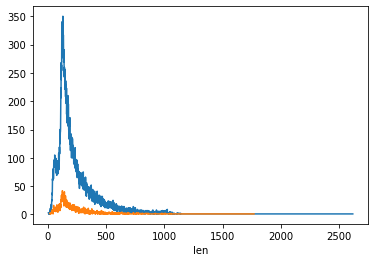

In [5]:
tmp = train_data.groupby("len").size()
display(train_data["len"].describe())
display(tmp.plot())

tmp1 = test_data.groupby("len").size()
display(test_data["len"].describe())
tmp1.plot()

In [6]:
## fix zz...

import copy
zz=pd.DataFrame( {
    "text":pd.Series(reviews), 
    "tokens":pd.Series(copy.deepcopy(tokenized_reviews)), 
    "label":pd.Series(y)
})
zz["len"] = [ len(x) for x in zz["tokens"] ]

# split the data into Train/test based on the md5 hash...
zz["hash"] = [ hashlib.md5(x.encode('ascii')).hexdigest() for x in zz["text"] ]
zz["Test"] = [ (int(x,16) % 100 > 90) for x in zz["hash"]]

train_data = copy.deepcopy(zz)[zz["Test"] == False] 
test_data =  copy.deepcopy(zz)[zz["Test"] == True] 
print(train_data.shape)
print(test_data.shape)

t1 = time.process_time()
print("time: ",(t1-t0)," sec" )


(45380, 6)
(4620, 6)
time:  170.126269  sec


Add the Start/End tokens...

In [7]:
## reset the training data ...
train_data = copy.deepcopy(zz)
train_data = train_data[train_data["Test"] == False ]
test_data = copy.deepcopy(zz)
test_data = test_data[test_data["Test"] == True]

def addSpecialTokens(lst,maxValues):
    lst=lst[:maxValues-2]
    lst.insert(0,101)
    lst.append(102)
    return lst;

#test_data["tokens"].apply(lambda x:x.insert(0,1))
test_data["tokens"]=test_data["tokens"].apply(addSpecialTokens,args=(300,))
train_data["tokens"]=train_data["tokens"].apply(addSpecialTokens,args=(300,))

# print the values out ....
print("tokenized_reviews:",tokenized_reviews[6][0:10],"len:",len(tokenized_reviews[6]))
print("zz:",zz.iloc[6,1][0:10],"len:",len(zz.iloc[6,1]))
print("test_data:",test_data.iloc[0,1][0:10],"len:",len(test_data.iloc[0,1]))

print("train_data:",train_data.iloc[0,1][0:10],"len:",len(train_data.iloc[0,1]))

tokenized_reviews: [1045, 2469, 2052, 2066, 2000, 2156, 15218, 1997, 2039, 6052] len: 155
zz: [1045, 2469, 2052, 2066, 2000, 2156, 15218, 1997, 2039, 6052] len: 155
test_data: [101, 1045, 2469, 2052, 2066, 2000, 2156, 15218, 1997, 2039] len: 157
train_data: [101, 2028, 1997, 1996, 2060, 15814, 2038, 3855, 2008, 2044] len: 300


In [8]:
t0 = time.process_time()
model_dir = "/Users/druss/Downloads/uncased_L-12_H-768_A-12"

bert_params = bert.params_from_pretrained_ckpt(model_dir)
l_bert = bert.BertModelLayer.from_params(bert_params, name="bert")

t1 = time.process_time()
print("time: ",(t1-t0)," sec" )

time:  0.005697999999995318  sec


In [9]:
t0 = time.process_time()

import os
from tensorflow import keras

max_seq_len = 300
l_input_ids      = keras.layers.Input(shape=(max_seq_len,), dtype='int32')
l_token_type_ids = keras.layers.Input(shape=(max_seq_len,), dtype='int32')

# using the default token_type/segment id 0
output = l_bert(l_input_ids)                              # output: [batch_size, max_seq_len, hidden_size]
model = keras.Model(inputs=l_input_ids, outputs=output)
model.build(input_shape=(None, max_seq_len))

bert_ckpt_file   = os.path.join(model_dir, "bert_model.ckpt")
bert.load_stock_weights(l_bert, bert_ckpt_file)

t1 = time.process_time()
print("time: ",(t1-t0)," sec" )

Done loading 196 BERT weights from: /Users/druss/Downloads/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x6a0e550d0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
time:  21.638244999999984  sec


ok, we now have the pretrained bert model loaded...  we need get the input in a format bert can ingest.  We need masks to ignore tokens in the sentence that are longer than the max seq length. (which we define in the cell above as 300)


In [12]:
def get_masks(tokens, max_seq_length):
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))


def get_segments(tokens, max_seq_length):
    return  [0] * (max_seq_length )



def pad_tokens(tokens,max_seq_length):
    padded = tokens + [0]*(max_seq_length - len(tokens))
    return padded

In [13]:
MAX_SEQ_LEN=300
# before we pad the data, make a mask and segments, which are all 0 in our case ...
test_data["mask"] = test_data.iloc[:,1].apply(get_masks,args=(MAX_SEQ_LEN,))
train_data["mask"] = train_data.iloc[:,1].apply(get_masks,args=(MAX_SEQ_LEN,))

# one of bert's training has does sentence 2 follow sentence 1.
# we are not useing that method, so just fill the array with 0.
test_data["segments"] = test_data.iloc[:,1].apply(get_segments,args=(MAX_SEQ_LEN,))
train_data["segments"] = train_data.iloc[:,1].apply(get_segments,args=(MAX_SEQ_LEN,))


### Pad the data (Tokens only)...
test_data.iloc[:,1] = test_data.iloc[:,1].apply(pad_tokens,args=(MAX_SEQ_LEN,))
train_data.iloc[:,1] = train_data.iloc[:,1].apply(pad_tokens,args=(MAX_SEQ_LEN,))


In [14]:
model.predict

<bound method Model.predict of <tensorflow.python.keras.engine.training.Model object at 0x6a0e08c90>>

In [15]:
test_data

,text,tokens,label,len,hash,Test,mask,segments
6,I sure would like to see resurrection of up da...,"[101, 1045, 2469, 2052, 2066, 2000, 2156, 1521...",1,155,c5c4cf73513dcc56ffa4407cb8f122a4,True,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
42,Of all the films have seen this one The Rage h...,"[101, 1997, 2035, 1996, 3152, 2031, 2464, 2023...",0,176,918df352afa5d7e2a748646b72ce60a7,True,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
49,Average and surprisingly tame Fulci giallo whi...,"[101, 2779, 1998, 10889, 24763, 11865, 15472, ...",0,109,a413870abe8e351ce249fe335d9f49c3,True,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
63,Besides being boring the scenes were oppressiv...,"[101, 4661, 2108, 11771, 1996, 5019, 2020, 285...",0,52,d6a8db3df658403e551729e62e252449,True,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
70,Caddyshack Two is good movie by itself but com...,"[101, 28353, 5149, 7377, 3600, 2048, 2003, 220...",0,244,c88650c3f57fa56441954230f7f6bfd1,True,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...
49959,My thoughts on the movie It was not good not g...,"[101, 2026, 4301, 2006, 1996, 3185, 2009, 2001...",0,600,990a38643201beeec2f631f932a1089d,True,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
49963,If you like really shocking movies this is for...,"[101, 2065, 2017, 2066, 2428, 16880, 5691, 202...",0,65,6ef33ea069803a156c0b36352559a890,True,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
49964,I saw this last week during Bruce Campbell boo...,"[101, 1045, 2387, 2023, 2197, 2733, 2076, 5503...",1,227,8f36c2e162da5eadbbc0e7e6046b869b,True,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
49983,I loved it having been fan of the original ser...,"[101, 1045, 3866, 2009, 2383, 2042, 5470, 1997...",1,127,d365dcede861bf5ae05584760b70388d,True,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
input_tokens   = test_data.loc[:,"tokens"].tolist()
input_masks    = test_data.loc[:,"mask"].tolist()
input_segments = test_data.loc[:,"segments"].tolist()

pool_embs, all_embs = model.predict([[input_tokens][0],[input_masks][0],[input_segments][0]])